# Model Interpretability

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

One of the advantages of linear models is that it is simple to interpret the effect of features on the predictions of the model. By inspecting the coefficients you can determine the final effect of the model prediction. For example, for a linear regression model

$$ y = c_1 x_1 + c_2 x_2 + \cdots + c_n x_n, $$

then if $x_1$ is changed by a small amount $\Delta x$, then the resulting change in $y$ will be $c_1 \Delta x$. For a classification problem this change in $y$ is then an input to the logistic function which determines the probability. If $c_1$ is negative then $y$ and $x_1$ are then negatively correlated, i.e., a positive value of $\Delta x$ will decrease $y$. Hence, for a linear model, which includes Ridge and Lasso regularization, and linear SVM, the coefficients give us global and local interpretability. That is, they inform us about the consequence of small changes in the features for individual observations and for the overall output of the model. The other advantage of the coefficients of linear models, is that there is no extra cost to calculate these.

We have also discussed model interpretability with tree based models such as Decision Trees and Random Forests. These models return the feature importance field, which determines how much a feature contributes to reducing the weighted Gini score (impurity) or entropy for classification problems, or the variance for regression problems. By ranking the features we can investigate which features have the most significant effect on creating the tree. Again this is easy to interpret and fast to calculate. However, these do not inform us about changes in individual observations, including the directionality of changes. The feature importance also favours continuous features or categorial features with a large number of options.

For black box models such as k-Nearest Neighbours or artificial neural networks it becomes much more difficult to interpret the output of a model, and having such observations could be crucial in convincing a client of the suitability of a model, or trying to understand why a model predicts a medical condition.

In this activity we will introduce two modern techniques for interpreting models: LIME and SHAP. 

## Contents

* Problem setup
* Coefficients of the linear model
* Feature importance for tree models
* LIME values
* SHAP values
* Exercises

## Problem setup 

We will again use the Abalone dataset, which can be downloaded from [Monash Gitlab](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Imputation/abalone.csv). This will need to be saved in your working directory.

You will probably need to uncomment the following cell to install the required packages.

In [3]:
!pip3 install -U lime
!pip3 install -U shap
!pip3 install -U seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=d7d8dde07a01c0162468df33c02f833ec56bf4ff22e6a2e981bf03799ff3be30
  Stored in directory: /Users/farrelw/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/f5/1f/21a1c97b2fca7629c2721ccdb565a4b24f6a66a11106f066e0849c0bd9a8/shap-0.43.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/17.0 MB 185.7 kB/s eta 0:01:00^C
     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/17.0 MB 185.4 kB/s eta 0:01:00
ERROR: Operation cancelled by user
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seab

Now we import the usual libraries, and the LIME and SHAP libraries.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lime
import shap

Then we can read in the abalone dataset and save to a dataframe. This is a clean dataset, so no need for any extensive preprocessing. Recall that the age can be calculated as $Age = Rings+1.5$.

In [3]:
abalone = pd.read_csv("abalone.csv")
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The only requirement for modelling is that we convert the `Sex` field to categorical columns. This field has three values: `M` - male, `F` - female and `I` - infant. Then the `Sex` field can be dropped.

In [4]:
dummy = pd.get_dummies(abalone['Sex'])
abalone = pd.concat([abalone, dummy], axis=1)
abalone.drop(columns=['Sex'], inplace=True)
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


As this is a regression problem the simplest understanding comes from inspecting the correlation coefficients. We drop the categorical fields and then can compare the correlation for all the other variables. There is considerable multi-collinearity, especially between `Diameter` and `Length`, however we will ignore that here. We can set up reduced models, but these do not have the same accuracy as the full dataset. The length measurements all seem to have a similar effect on `Rings`, while the weight measurements have slightly varying effect.

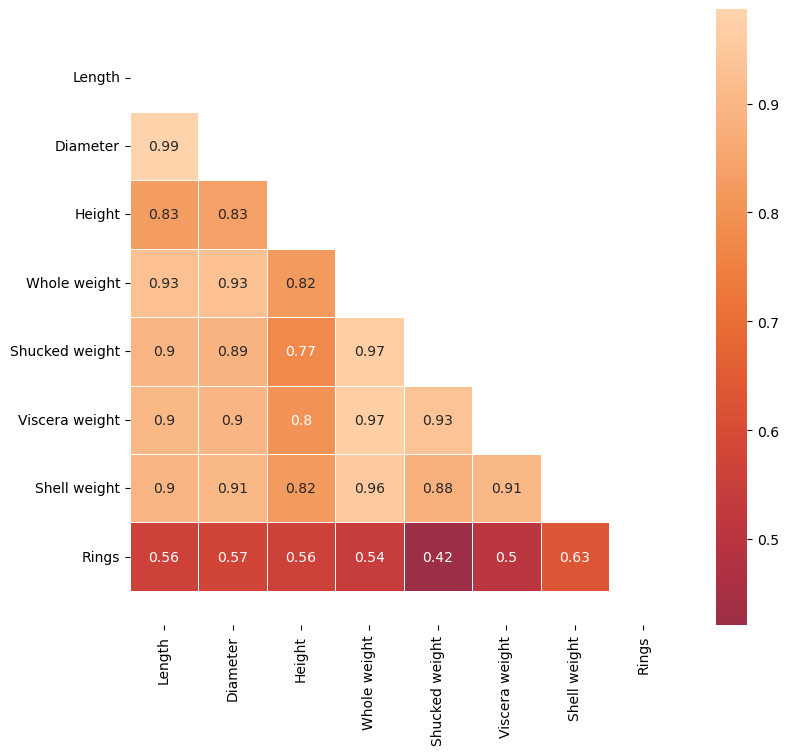

In [5]:
corrs = abalone.drop(columns=['M', 'F', 'I']).corr() # calculate the correlation table
# as this is a symmetric table, set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=bool)) 
f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5);

## Coefficients of the linear model

For the linear model we set up a features array and a target array. The routine `np.ravel()` flattens the target array to a vector. We can eliminate one of the variables `M`, `F` or `I`, since the sum of these is one. In this case we eliminate `I`. This is done to make all the coefficients of similar magnitude.

In [6]:
Xf = abalone.drop(columns=['I', 'Rings'])
Yf = np.ravel(abalone[['Rings']])

The creation of the linear model with `sklearn` follows the usual workflow: split the dataset, instantatiate the model, fit the training data to the model, create predictions for the testing set and compare these with the actual labels. The accuracy is reasonable, considering there is no tuning of the model.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0) 

linmodel = LinearRegression() 
linmodel.fit(X_train, Y_train)
Y_pred = linmodel.predict(X_test) 
acc = r2_score(Y_test,Y_pred) 
print("Testing score is %5.3f" % acc)

Testing score is 0.539


By inspecting the coefficients we can now understand what features have the most significant effect on the output of the model. This shows that if the features increase by the same amount, then `Shucked weight`, followed by `Diameter` and `Viscera weight`, have the largest effect. However, we see that the model predicts that as `Shucked weight` and `Viscera weight` increase, then the age decreases, which appears to be counterintuitive.

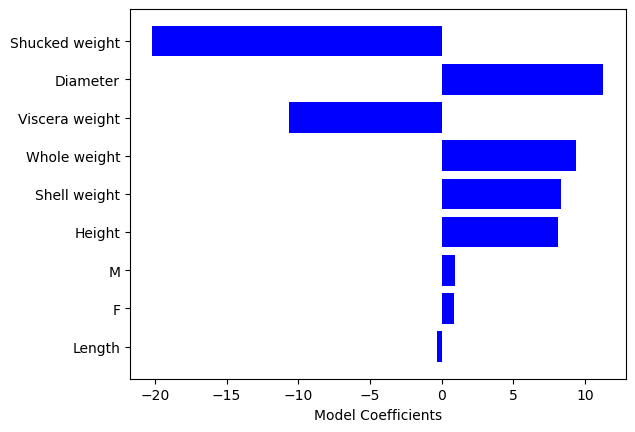

In [8]:
importances = linmodel.coef_
indices = np.argsort(np.abs(importances))

features = X_train.columns
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Model Coefficients');

To understand the feature importance, i.e., the overall significance of the feature on the model, we need to take into account how much each variable changes, which is characterised by the standard deviation. For example, when `M` and `F` vary they will always vary by one, whereas the variation of all the other variables depends on the units they are measured in. Therefore we can calculate the feature importance by multiplying the coefficients by the standard deviation of each variable. This gives that for the linear model that `Whole weight` is the most significant variable. This is again to be expected as `Whole weight` is the sum of all the other weights, and so should have higher variance. The negative effects of `Shucked weight` and `Viscera weight` can then be understood as compensatory effects for the increase in `Whole weight`. Now the effect of the length variables drops in comparison to all the other variables.

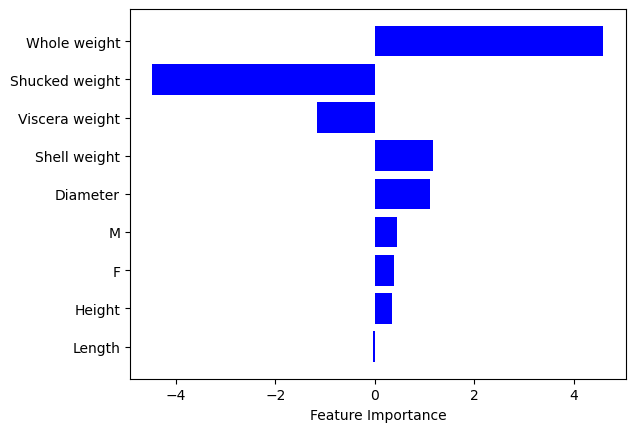

In [9]:
scaled_importances = importances*Xf.std()
indices = np.argsort(np.abs(scaled_importances))

features = X_train.columns
plt.barh(range(len(indices)), scaled_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance');

## Feature importance for tree models

To investigate feature importance for tree models we just need to access the corresponding field for the model. First, we will set up a simple Random Forest regression model. Since this is a nonlinear model, this gives an improved accuracy compared the linear regression model.

In [10]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0) 
rfc = RandomForestRegressor() 
rfc.fit(X_train, Y_train) # fit the data to the model
Y_pred = rfc.predict(X_test) 
acc = r2_score(Y_test,Y_pred) 
print("Testing score is %5.3f" % acc)

Testing score is 0.574


We can now access the feature importance. In this case it corresponds to the weighted effect on the splitting of the variance in creating the ensemble of trees. This is a relative effect, where the sum of the feature importance is one, hence there is no need to normalize this variable to understand the importance. Now we see that the feature importance generally follows the ranking that was obtained for the linear regression model. However, there is no indication of whether the particular variables have a positive or negative effect.

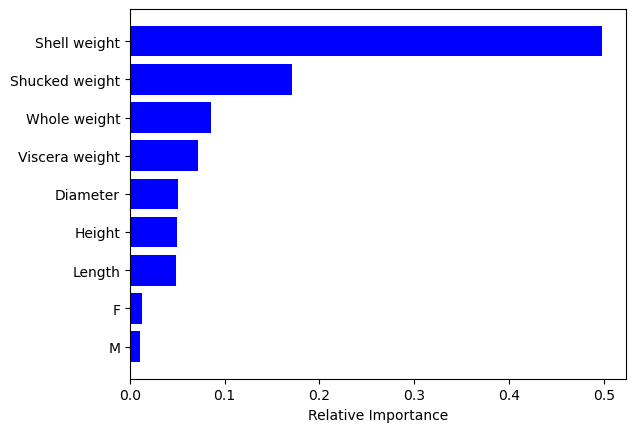

In [11]:
importances = rfc.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

## LIME values

Lime (local interpretable model-agnostic explanations) is a package which can be used to explain individual observations from a model. A full explanation of the package can be found on [github](https://github.com/marcotcr/lime). Essentially what the package does is to take observations in the vicinity of the observation of interest and create a linear model, where the importance of the other observations is weighted by distance from the observation of interest. This then causes any nonlinear regression or classification boundary to become linear. In terms of multivariable calculus, this can be thought of as taking the tangent to the model. Hence, Lime only gives local interpretability. However, its main advantage is that it is relatively quick to calculate and can be used for any machine learning model. 

Lime can be used for classification, multi-label classification and regression problems. We will just consider regression problems.

The first step is to create an explainer for the model that you want to interpret. We will do this for the Random Forest model we previously created.

In [12]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=features,
                                                   verbose=True,
                                                   mode='regression')

Then we use the explainer to interpret a particular instance for this model. We also need to pass the prediction function for the model, so that the labels around this particular instance can be calculated. The explainer outputs three diagnostics. The first is the intercept, which is the value for the local model when all Lime values are zero. The second value is the prediction of the linear model, and the third is the prediction of the nonlinear model (i.e., in this case the Random Forest regressor).

Once we have instantatiated the explainer for this particular instance, we can print the Lime values as a list. The Lime values are the second value in the array, while the first field shows the variance of that particular feature. The Lime values can be thought of as the local linear feature importance for the nonlinear model, i.e., coefficients values multiplied by the standard deviation. In this particular instance we again see that the weights are the most important features. The `Whole weight`  and `Shell weight` have negative effects, and so, reduce the number of rings from the value at the intercept, whereas `Shucked weight` will increase the number of rings.

In [13]:
print("Explainer diagnostics")
print("\n")
exp = explainer.explain_instance(X_test.iloc[1,:], rfc.predict)
print("\n")
print("Lime values")
exp.as_list()

Explainer diagnostics


Intercept 12.030976624175606
Prediction_local [11.13097585]
Right: 10.47


Lime values


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


[('0.19 < Shucked weight <= 0.34', 1.0103538031291772),
 ('0.44 < Whole weight <= 0.81', -0.5502540425253651),
 ('0.13 < Shell weight <= 0.23', -0.5477145439811693),
 ('M <= 0.00', -0.38240178900489263),
 ('0.12 < Height <= 0.14', -0.35550291245846366),
 ('F <= 0.00', -0.10903328949729493),
 ('0.09 < Viscera weight <= 0.17', 0.07729221148314248),
 ('0.35 < Diameter <= 0.42', -0.04048330977184669),
 ('0.45 < Length <= 0.55', -0.002256901263623451)]

By summing the Intercept and Lime values, we obtain the Local Prediction (check this for yourself).

A more useful way to show this is graphically as a `matplotlib` figure, by using the method `as_pyplot_figure()`. There is also a javascript method `show_in_notebook()`, which shows extra information. However, this is not as transferable. 

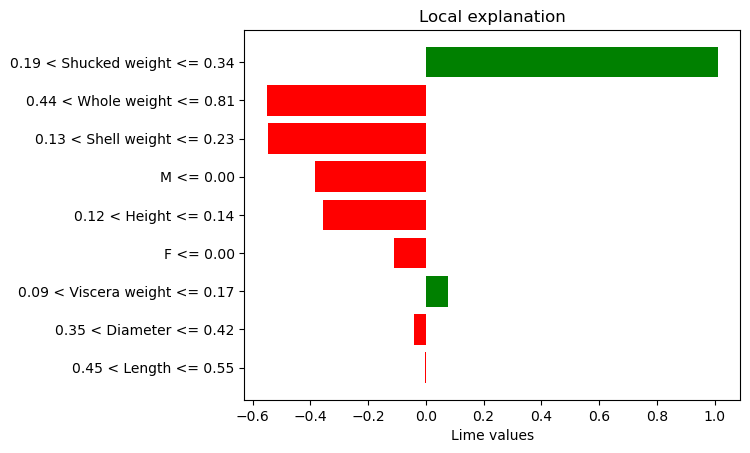

In [14]:
exp.as_pyplot_figure()
plt.xlabel('Lime values');

The javascript figure also shows where the nonlinear model value lies on the continuum of predicted values, and displays the Lime values graphically along with the feature values for this particular instance.

For another instance the most important feature is now `Shell weight`, although the other variables have Lime values similar to previously.

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Intercept 13.070571389886481
Prediction_local [8.16255289]
Right: 8.35


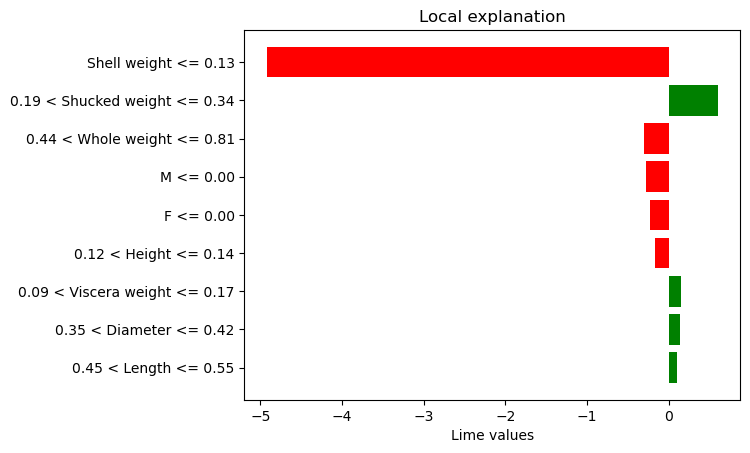

In [15]:
exp = explainer.explain_instance(X_test.iloc[10,:], rfc.predict)
exp.as_pyplot_figure()
plt.xlabel('Lime values');

## SHAP values

Although Lime values are fast to calculate, they only give local interpretability. A package which attempts to show both local and global interpretability is the Shap package. For a detailed description of this package see this [documentation](https://shap.readthedocs.io/en/latest/overviews.html). The output of this package is very helpful in interpreting models, but it has the disadvantages that:
* It is very computationally expensive, especially for general nonlinear models. 
* Documentation is sketchy.
* It may not work on laptops.

What the Shap package calculates is the mean contribution of each feature to the deviation of the labels from the mean value, over all possible permutations of the features. If you have a large number of features you can see this will become very expensive to calculate. The output is the Shap values, which are similar to Lime values, in that they show how much the feature causes the label to change from the mean value for the dataset.

The computationally expensive part is calculating the explainer, and then calculating the Shap values for the particular dataset. We use the testing dataset here, as it is signicantly smaller than the training set. Again we introduce the Shap values using the Random Forest regression model. As with the Lime package, the Shap package can also be used to interpret classification problems.

In [16]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

This can be used to inspect the overall feature importance, similar to what was done using the output of the Random Forest regression. The ranking of variables is similar to that from the Random Forest regression.

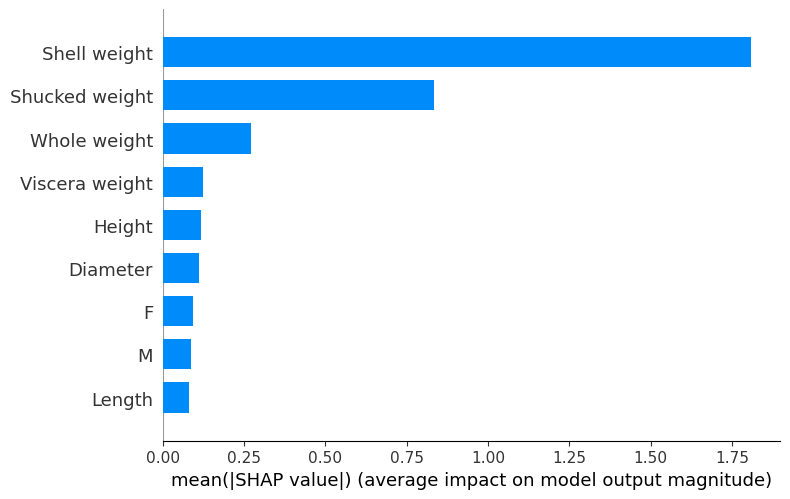

In [17]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

We can now inspect the Shap values for particular instances. The sum of the Shap values for a particular instance correspond to the difference between the mean label value for the dataset and the actual model value for this instance. Blue Shap values cause the model value to decrease, and red values cause the model value to increase. This is depicted by the arrow directions in the force plot. Then shown at the bottom of the figure are the feature values for this instance. Here the main contributers are `Shell weight` which has a value of 0.1935 and a negative effect, and `Shucked weight` which has a value of 0.261 and a positive effect. The overall 'force' from the red values in this case is greater than for the blue values, which causes the label value for this instance to be slightly higher than the mean.

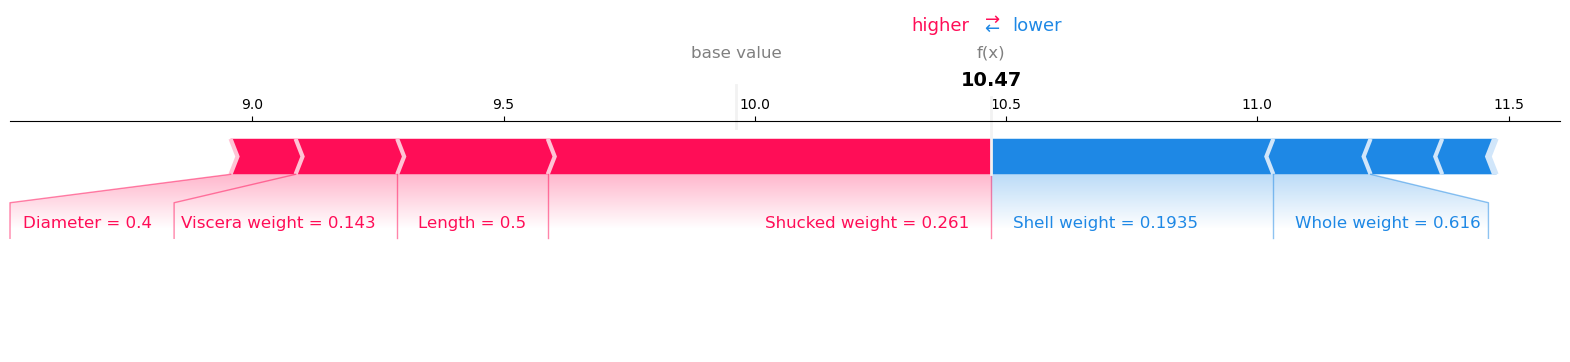

In [18]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:], matplotlib=True)

For another instance we now see that the blue effects are much stronger than the red effects, which causes a significant decrease in the label value for this instance from the mean value. The value of `Shell weight` has decreased which has caused the magnitude of the Shap value to increase, whereas for `Shucked weight` the feature value has also decreased, but this has caused the magnitude of the Shap value to decrease.

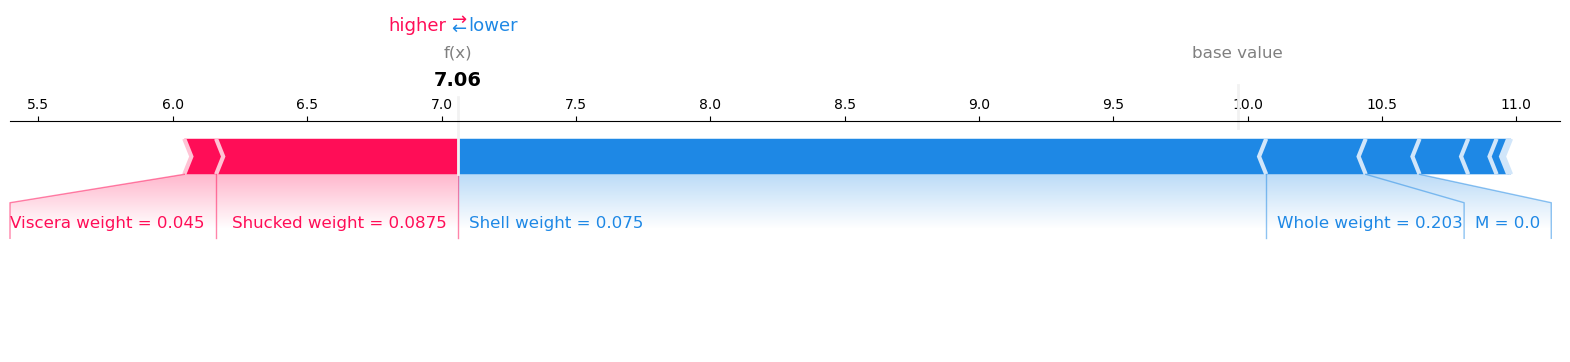

In [19]:
shap.force_plot(explainer.expected_value, shap_values[20,:], X_test.iloc[20,:], matplotlib=True)

The global effect of all the Shap values can be demonstrated using the summary plot. This shows all the Shap values on a 'swarm' plot, where the thickness of the line corresponds to the density of instances for that value. Each individual point is then coloured by the relative feature value. To interpret this figure, we see that `Shell weight` has the widest distribution of Shap values, and consequently has the most significant effect on the variation of the label. For relatively low values of `Shell weight` the Shap value is negative, whereas for relatively high values of `Shell weight` the Shap value is positive. Whereas for the next ranked feature `Shucked weight` the opposite applies. Hence `Shucked weight` is a compensatory effect for `Shell weight`. For these two features the Shap values have a smooth distribution. However for all the features from `Viscera weight` downwards, the Shap values are centred about zero, which suggests that these features do not have a significant effect on the model output.

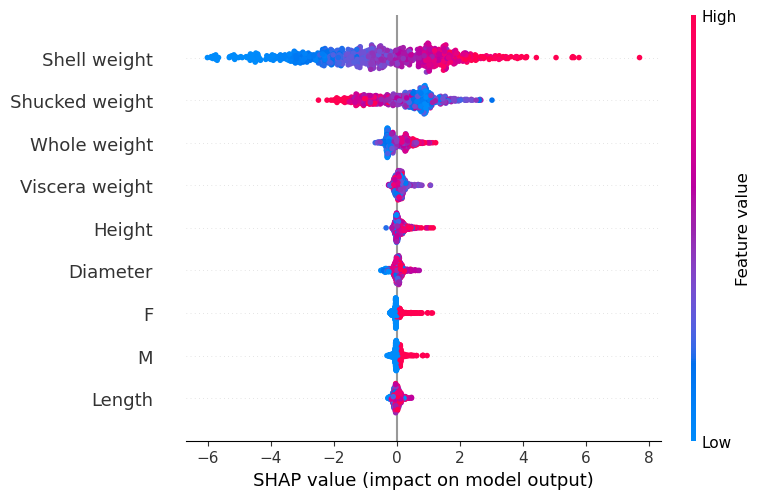

In [20]:
shap.summary_plot(shap_values, X_test)

## Exercises

## Exercise 1 (2 marks)

Fit a kNN regression model with 10 nearest neighbours to the abalone data and calculate the accuracy.

In [23]:
from sklearn.neighbors import KNeighborsRegressor

X = abalone.drop(columns=['I', 'Rings'])
y = abalone['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the kNN regression model with 10 nearest neighbors
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = r2_score(y_test, y_pred)
print("Testing score (R-squared) is %5.3f" % accuracy)

Testing score (R-squared) is 0.553


## Exercise 2 (2 marks)

Calculate and display the Lime values for the kNN model for one particular instance of the test data. (You should be able to use similar code as used earlier in the notebook.)

In [25]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=features,
                                                   verbose=True,
                                                   mode='regression')

print("Explainer diagnostics")
print("\n")
exp = explainer.explain_instance(X_test.iloc[1,:], rfc.predict)
print("\n")
print("Lime values")
exp.as_list()

Explainer diagnostics


Intercept 12.079656121388208
Prediction_local [11.20956518]
Right: 10.47


Lime values


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


[('0.19 < Shucked weight <= 0.34', 0.8305068665728799),
 ('0.13 < Shell weight <= 0.23', -0.522068778766667),
 ('0.44 < Whole weight <= 0.81', -0.5049787315540211),
 ('F <= 0.00', -0.361251437126474),
 ('M <= 0.00', -0.2117557351601235),
 ('0.12 < Height <= 0.14', -0.14723871582891238),
 ('0.09 < Viscera weight <= 0.17', 0.03388574433136251),
 ('0.45 < Length <= 0.55', 0.010732337566951603),
 ('0.35 < Diameter <= 0.42', 0.0020775104433697154)]

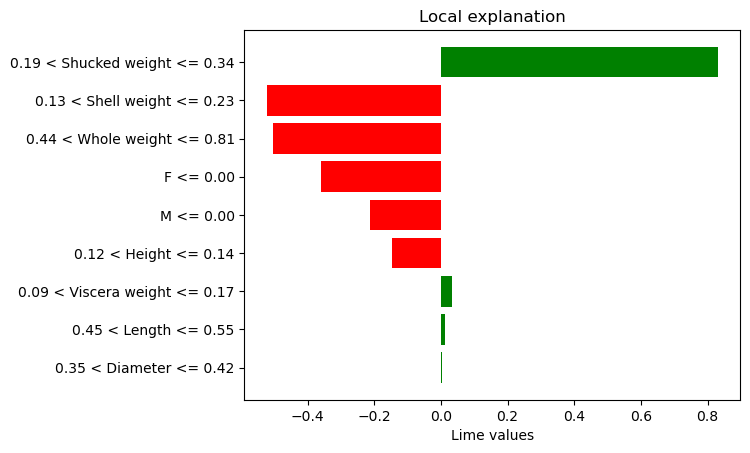

In [26]:
exp.as_pyplot_figure()
plt.xlabel('Lime values');

## Exercise 3 (2 marks)

Using a random sample of 200 observations from the test data (use df.sample()), calculate the Shap values for the kNN model. You will need to use `shap.KernelExplainer()` (see the [documentation](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html), the two inputs are the model prediction and the feature sample). On Google Colab this calculation will take about 10 minutes.

In [28]:
import random

random.seed(42)
sample_size = 200
sample_indices = random.sample(range(len(X_test)), sample_size)
sample_data = X_test.iloc[sample_indices]

feature_sample = sample_data.values
knn_explainer = shap.KernelExplainer(knn_model.predict, feature_sample)
shap_values = knn_explainer.shap_values(feature_sample)

print("Shap values for the first observation:")
print(shap_values[0])

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

Shap values for the first observation:
[-0.09716607 -0.11734464 -0.16892083 -2.45434107  1.12660298  0.08642202
 -0.75862202 -0.31339464 -0.40223571]


## Exercise 4 (4 marks)

Create a 'swarm' summary plot of the Shap values. List two significant conclusions regarding the model you can draw from this plot.

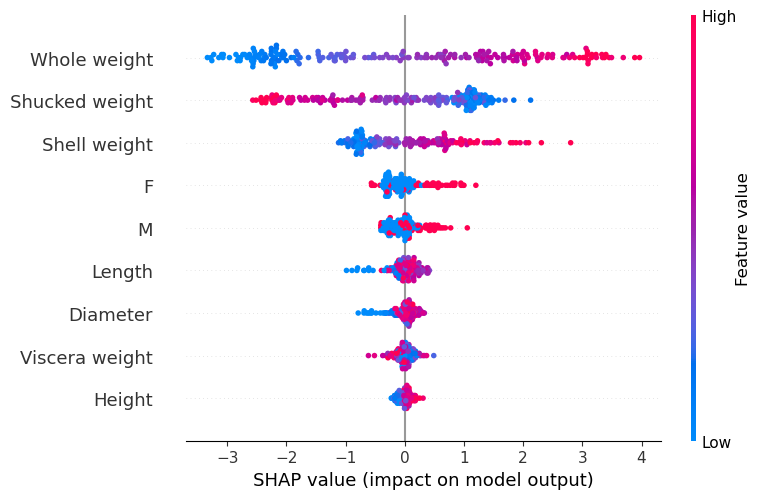

In [35]:
shap.summary_plot(shap_values, sample_data) 

Conclusions:

- Overall, weight-related factors have a significant influence in determining the target variable, making up to top-three most important variables.

- 'Whole weight' has  the wwidest distribution of snap values, consequently have a great affect on the label's variation.

### Generative AI Acknowledgement

If you used generative AI to assist you with these excercises, document your use below following the guidelines here: https://www.monash.edu/learnhq/build-digital-capabilities/create-online/acknowledging-the-use-of-generative-artificial-intelligence